Note:
All files including `requirements.txt`, `trained models` and `results` have been uploaded [here](https://drive.google.com/drive/folders/1ZsqyPbnFURskLgf0ZwOVKaKDrFP6BjnO?usp=sharing).

You can load models for repoducibility. (code provided in the [cell](https://colab.research.google.com/drive/1xLKq2DW8EF6pMZFtNCE09lKiuatYKIq9#scrollTo=LniHijv347NQ&line=16&uniqifier=1))



In [2]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/
%cd DL/
!ls

Mounted at /content/gdrive
/content/gdrive/My Drive
/content/gdrive/My Drive/DL
 CNN_model   DL_hw_CNN.csv   epoch_acc_validation  'loss plot.png'
 data.pth    epoch_acc	     epoch_loss		    requirements.txt


In [0]:
# download the data if you don't wanna mount gdrive

# !wget https://www.dropbox.com/s/h1n73cw33no99mz/data.pth

In [0]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Use a fixed random seed for reproducibility.
# Use a fixed random seed for reproducibility.
# Use a fixed random seed for reproducibility.
np.random.seed(0)
torch.manual_seed(0)


# cudnn
torch.backends.cudnn.version()
# torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Strategy 1 

Simple CNN

ref: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html


In [31]:
train_x, train_y, dev_x, dev_y, test_x = torch.load('data.pth')

print('Training size:', train_x.shape, train_y.shape)
print('Development size:', dev_x.shape, dev_y.shape)
print('Test size:', test_x.shape)


train_x , train_y, dev_x, dev_y, test_x = train_x/255, train_y, dev_x/255, dev_y,test_x/255

def normalize_stats_image_by_image(images):
  mean = images.mean(axis=(1,2,3), keepdims=True)
  stdev = images.std(axis=(1,2,3), keepdims=True)
  return (images - mean) / stdev


train_x_ = normalize_stats_image_by_image(train_x)
dev_x_ = normalize_stats_image_by_image(dev_x)
test_x_ = normalize_stats_image_by_image(test_x)

Training size: (45000, 3, 32, 32) (45000,)
Development size: (5000, 3, 32, 32) (5000,)
Test size: (10000, 3, 32, 32)


In [0]:
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
class MyDataset(Dataset):
    def __init__(self, sample_x, sample_y, transform=None):
      self.sample_x = sample_x
      self.sample_y = sample_y
      self.transform = transform

    def __getitem__(self, idx):   
      if self.transform is not None:
        self.sample_x[idx] = self.transform(self.sample_x[idx])
      return self.sample_x[idx], self.sample_y[idx]

    def __len__(self):
      return len(self.sample_x)



sample_x = torch.from_numpy(train_x).to(device=device, dtype=torch.float)
sample_y = torch.from_numpy(train_y).to(device=device, dtype=torch.long)
train_dataset = MyDataset(sample_x, sample_y)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=200, shuffle=True)


test = torch.utils.data.TensorDataset(torch.from_numpy(dev_x).to(device=device, dtype=torch.float), torch.from_numpy(dev_y).to(device=device, dtype=torch.long))
testloader = torch.utils.data.DataLoader(test, batch_size=200, shuffle=False)

In [0]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net()
model.cuda()


import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [26]:
epoch_loss = []
epoch_acc = []
epoch_acc_validation = []

for epoch in range(100):  # loop over the dataset multiple times
    model.train()
    running_loss = 0.0
    running_correct = 0.0
    running_total = 0
    # for i, data in enumerate(trainloader, 0):
    for inputs, labels in trainloader:
        # get the inputs; data is a list of [inputs, labels]

        inputs, labels = inputs.to(device = device), labels.to(device = device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        

        running_correct += (predicted == labels).sum().item()        
        running_loss += loss.item()
        running_total += labels.shape[0]
        # note running_total = len(train_dataset) = batch_size * len(trainloader)

    epoch_loss.append(running_loss/ running_total)
    epoch_acc.append(running_correct / running_total)

    model.eval()
    pred_res = [] # prediction results after each training epoch
    correct = 0
    total = 0
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        # predicted to cpu
        pred_res.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()



    epoch_acc_validation.append(correct / total)


    print('Epoch: %d Loss: %.3f Training Accuracy: %.3f Validation Accuracy: %.3f' %
                  (epoch + 1,
                   running_loss/ running_total,
                   running_correct / running_total,
                   correct / total)
                  )
          
print('Finished Training')

Epoch: 1 Loss: 0.023 Training Accuracy: 0.010 Validation Accuracy: 0.009
Epoch: 2 Loss: 0.023 Training Accuracy: 0.018 Validation Accuracy: 0.032
Epoch: 3 Loss: 0.021 Training Accuracy: 0.055 Validation Accuracy: 0.072
Epoch: 4 Loss: 0.020 Training Accuracy: 0.092 Validation Accuracy: 0.111
Epoch: 5 Loss: 0.019 Training Accuracy: 0.122 Validation Accuracy: 0.136
Epoch: 6 Loss: 0.018 Training Accuracy: 0.147 Validation Accuracy: 0.156
Epoch: 7 Loss: 0.018 Training Accuracy: 0.170 Validation Accuracy: 0.171
Epoch: 8 Loss: 0.017 Training Accuracy: 0.191 Validation Accuracy: 0.194
Epoch: 9 Loss: 0.016 Training Accuracy: 0.208 Validation Accuracy: 0.202
Epoch: 10 Loss: 0.016 Training Accuracy: 0.230 Validation Accuracy: 0.216
Epoch: 11 Loss: 0.016 Training Accuracy: 0.242 Validation Accuracy: 0.229
Epoch: 12 Loss: 0.015 Training Accuracy: 0.260 Validation Accuracy: 0.232
Epoch: 13 Loss: 0.015 Training Accuracy: 0.272 Validation Accuracy: 0.254
Epoch: 14 Loss: 0.014 Training Accuracy: 0.289 

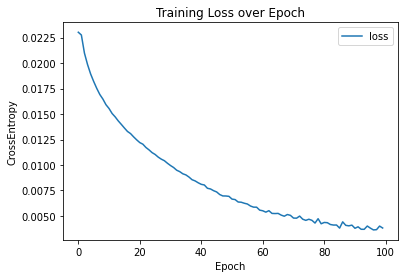

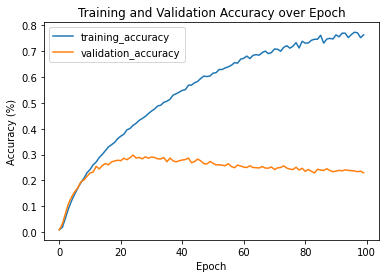

In [29]:
import matplotlib.pyplot as plt

plt.plot(epoch_loss,label = 'loss')
plt.title('Training Loss over Epoch')
plt.xlabel('Epoch')
plt.ylabel('CrossEntropy')
plt.legend()
plt.show()
plt.savefig('loss plot.png')


plt.plot(epoch_acc,label = 'training_accuracy')
plt.plot(epoch_acc_validation, label = 'validation_accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.title('Training and Validation Accuracy over Epoch')
plt.legend()
plt.show()

# Strategy 2

More complicated CNN

change the following settings

1. architecture
2. dropout
3. batchnorm
4. skip connection
5. batch size, learning rate, learning rate schedulers and different optimizers


ref: https://zhenye-na.github.io/2018/09/28/pytorch-cnn-cifar10.html

In [34]:
train_x, train_y, dev_x, dev_y, test_x = torch.load('data.pth')

print('Training size:', train_x.shape, train_y.shape)
print('Development size:', dev_x.shape, dev_y.shape)
print('Test size:', test_x.shape)


train_x , train_y, dev_x, dev_y, test_x = train_x/255, train_y, dev_x/255, dev_y,test_x/255

def normalize_stats_image_by_image(images):
  mean = images.mean(axis=(1,2,3), keepdims=True)
  stdev = images.std(axis=(1,2,3), keepdims=True)
  return (images - mean) / stdev


train_x_ = normalize_stats_image_by_image(train_x)
dev_x_ = normalize_stats_image_by_image(dev_x)
test_x_ = normalize_stats_image_by_image(test_x)

Training size: (45000, 3, 32, 32) (45000,)
Development size: (5000, 3, 32, 32) (5000,)
Test size: (10000, 3, 32, 32)


In [0]:
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
class MyDataset(Dataset):
    def __init__(self, sample_x, sample_y, transform=None):
      self.sample_x = sample_x
      self.sample_y = sample_y
      self.transform = transform

    def __getitem__(self, idx):   
      if self.transform is not None:
        self.sample_x[idx] = self.transform(self.sample_x[idx])
      return self.sample_x[idx], self.sample_y[idx]

    def __len__(self):
      return len(self.sample_x)



sample_x = torch.from_numpy(train_x).to(device=device, dtype=torch.float)
sample_y = torch.from_numpy(train_y).to(device=device, dtype=torch.long)
train_dataset = MyDataset(sample_x, sample_y)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=200, shuffle=True)


test = torch.utils.data.TensorDataset(torch.from_numpy(dev_x).to(device=device, dtype=torch.float), torch.from_numpy(dev_y).to(device=device, dtype=torch.long))
testloader = torch.utils.data.DataLoader(test, batch_size=200, shuffle=False)

In [0]:
import torch.nn as nn


class Net(nn.Module):
    """CNN."""

    def __init__(self):
        """CNN Builder."""
        super(Net, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 100)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        # x = x.view(x.size(0), 16)
        # fc layer
        x = self.fc_layer(x)

        return x

model = Net()
model.to(device)








# optimization



import torch.optim as optim
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=opt.lr, weight_decay=opt.wd)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)





# for p in model.parameters():
#     print(p.device)

In [38]:
epoch_loss = []
epoch_acc = []
epoch_acc_validation = []

for epoch in range(100):  # loop over the dataset multiple times
    model.train()
    running_loss = 0.0
    running_correct = 0.0
    running_total = 0
    # for i, data in enumerate(trainloader, 0):
    for inputs, labels in trainloader:
        # get the inputs; data is a list of [inputs, labels]

        inputs, labels = inputs.to(device = device), labels.to(device = device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        

        running_correct += (predicted == labels).sum().item()        
        running_loss += loss.item()
        running_total += labels.shape[0]
        # note running_total = len(train_dataset) = batch_size * len(trainloader)

    epoch_loss.append(running_loss/ running_total)
    epoch_acc.append(running_correct / running_total)

    model.eval()
    pred_res = [] # prediction results after each training epoch
    correct = 0
    total = 0
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        # predicted to cpu
        pred_res.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()



    epoch_acc_validation.append(correct / total)


    print('Epoch: %d Loss: %.3f Training Accuracy: %.3f Validation Accuracy: %.3f' %
                  (epoch + 1,
                   running_loss/ running_total,
                   running_correct / running_total,
                   correct / total)
                  )
          
print('Finished Training')

Epoch: 1 Loss: 0.023 Training Accuracy: 0.019 Validation Accuracy: 0.032
Epoch: 2 Loss: 0.023 Training Accuracy: 0.033 Validation Accuracy: 0.038
Epoch: 3 Loss: 0.021 Training Accuracy: 0.050 Validation Accuracy: 0.073
Epoch: 4 Loss: 0.020 Training Accuracy: 0.075 Validation Accuracy: 0.099
Epoch: 5 Loss: 0.019 Training Accuracy: 0.101 Validation Accuracy: 0.114
Epoch: 6 Loss: 0.018 Training Accuracy: 0.128 Validation Accuracy: 0.148
Epoch: 7 Loss: 0.018 Training Accuracy: 0.154 Validation Accuracy: 0.170
Epoch: 8 Loss: 0.017 Training Accuracy: 0.179 Validation Accuracy: 0.181
Epoch: 9 Loss: 0.016 Training Accuracy: 0.201 Validation Accuracy: 0.216
Epoch: 10 Loss: 0.016 Training Accuracy: 0.227 Validation Accuracy: 0.225
Epoch: 11 Loss: 0.015 Training Accuracy: 0.249 Validation Accuracy: 0.238
Epoch: 12 Loss: 0.014 Training Accuracy: 0.272 Validation Accuracy: 0.287
Epoch: 13 Loss: 0.014 Training Accuracy: 0.289 Validation Accuracy: 0.296
Epoch: 14 Loss: 0.013 Training Accuracy: 0.311 

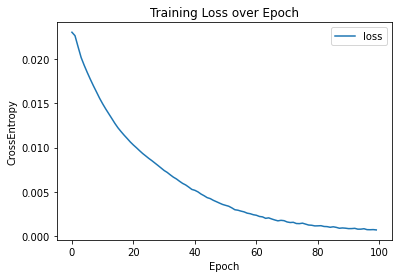

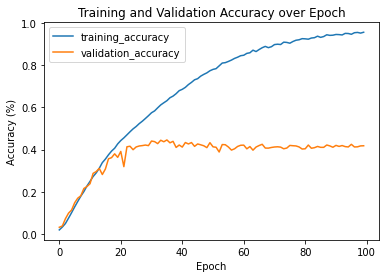

In [39]:
import matplotlib.pyplot as plt

plt.plot(epoch_loss,label = 'loss')
plt.title('Training Loss over Epoch')
plt.xlabel('Epoch')
plt.ylabel('CrossEntropy')
plt.legend()
plt.show()
plt.savefig('loss plot.png')


plt.plot(epoch_acc,label = 'training_accuracy')
plt.plot(epoch_acc_validation, label = 'validation_accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.title('Training and Validation Accuracy over Epoch')
plt.legend()
plt.show()

# Strategy 3


change the following settings

1. data augmentation (image rotation)
2. different normalization method
3. optimizer (Adam vs. SGD)

In [40]:
train_x, train_y, dev_x, dev_y, test_x = torch.load('data.pth')

print('Training size:', train_x.shape, train_y.shape)
print('Development size:', dev_x.shape, dev_y.shape)
print('Test size:', test_x.shape)


train_x , train_y, dev_x, dev_y, test_x = train_x/255, train_y, dev_x/255, dev_y,test_x/255

# https://github.com/Armour/pytorch-nn-practice/blob/master/utils/meanstd.py

def normalize_stats_image_by_image(images):
  CIFAR100_TRAIN_MEAN = np.asarray((0.5070751592371323, 0.48654887331495095, 0.4409178433670343)).reshape(1,3,1,1)
  CIFAR100_TRAIN_STD = np.asarray((0.2673342858792401, 0.2564384629170883, 0.27615047132568404)).reshape(1,3,1,1)
  return (images - CIFAR100_TRAIN_MEAN)/CIFAR100_TRAIN_STD

train_x = normalize_stats_image_by_image(train_x)
dev_x = normalize_stats_image_by_image(dev_x)
test_x = normalize_stats_image_by_image(test_x)

Training size: (45000, 3, 32, 32) (45000,)
Development size: (5000, 3, 32, 32) (5000,)
Test size: (10000, 3, 32, 32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


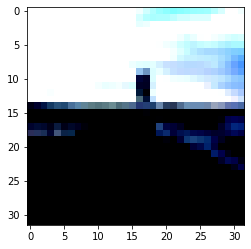

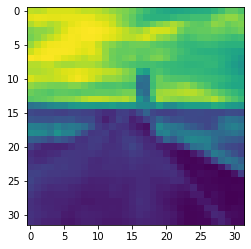

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 3, 32)
(3, 32, 32)
(32, 3, 32)


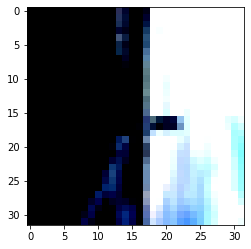

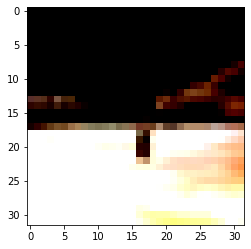

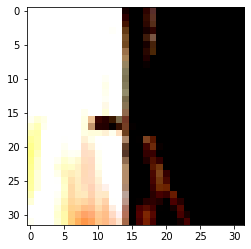

In [41]:
# show all three channels
plt.imshow(train_x[0].transpose((1, 2, 0)))
plt.show()

# show the first channel
plt.imshow(train_x[0, 0])
plt.show()



# rotation

a = np.rot90(train_x[0],1)
print(a.shape)
plt.figure()
plt.imshow(a.transpose((2,0,1)))


a = np.rot90(train_x[0],2)
print(a.shape)
plt.figure()
plt.imshow(a.transpose((1,2,0)))

a = np.rot90(train_x[0],-1)
print(a.shape)
plt.figure()
plt.imshow(a.transpose((2,0,1)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(180000, 3, 32, 32)
(180000,)


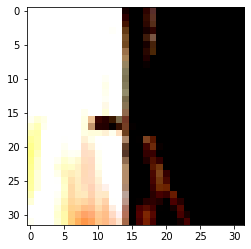

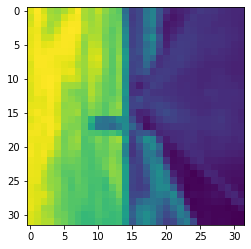

In [42]:
# augmentation rotation

train_x_1 = [np.rot90(j,1).transpose((1,2,0)) for j in train_x]
train_x_2 = [np.rot90(j,2) for j in train_x]
train_x_3 = [np.rot90(j,3).transpose((1,2,0)) for j in train_x]


train_x_1 = np.asarray(train_x_1)
train_x_2 = np.asarray(train_x_2)
train_x_3 = np.asarray(train_x_3)


train_x = np.concatenate((train_x,train_x_1,train_x_2,train_x_3))
train_y = np.concatenate((train_y,train_y,train_y,train_y))

# # randomly select data so as the same size of raw dataset
# idx = np.random.choice(len(train_x),int(len(train_x)/4),replace=False)
# train_x = train_x[idx]
# train_y = train_y[idx]


print(train_x.shape)
print(train_y.shape)
# show all three channels
plt.imshow(train_x_3[0].transpose((1, 2, 0)))
plt.show()

# show the first channel
plt.imshow(train_x_3[0, 0])
plt.show()

In [0]:
import torch.nn as nn


class Net(nn.Module):
    """CNN."""

    def __init__(self):
        """CNN Builder."""
        super(Net, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 100)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        # x = x.view(x.size(0), 16)
        # fc layer
        x = self.fc_layer(x)

        return x

model = Net()
model.to(device) # model=model().cuda()
# print(model)
# model.cuda()
# model.cpu()







# optimization



import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)





# for p in model.parameters():
#     print(p.device)

In [0]:
# train_data = []
# for i in range(len(train_x)):
#    train_data.append([train_x[i], train_y[i]])

# trainloader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=100)

# i1, l1 = next(iter(trainloader))
# print(i1.shape)


# # dataloader
# import torch.utils.data as data_utils
# train = data_utils.TensorDataset(torch.from_numpy(train_x).to(device=device, dtype=torch.float), torch.from_numpy(train_y).to(device=device, dtype=torch.long))
# trainloader = data_utils.DataLoader(train, batch_size=100, shuffle=True)
# i1, l1 = next(iter(trainloader))
# print(i1.shape)
# # print(i1)
# print(l1)




# https://discuss.pytorch.org/t/how-to-normalize-a-tensor-to-0-mean-and-1-variance/18766
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
class MyDataset(Dataset):
    def __init__(self, sample_x, sample_y, transform=None):
      self.sample_x = sample_x
      self.sample_y = sample_y
      self.transform = transform

    def __getitem__(self, idx):   
      if self.transform is not None:
        self.sample_x[idx] = self.transform(self.sample_x[idx])
      return self.sample_x[idx], self.sample_y[idx]

    def __len__(self):
      return len(self.sample_x)



# https://stackoverflow.com/a/56741326/11964524
# https://discuss.pytorch.org/t/how-can-i-convert-a-numpy-array-with-data-type-of-float32-from-nifti-image-to-pil-image/39221
# transformation = transforms.Compose([         
#                                      transforms.ToPILImage(),
#                                      transforms.RandomHorizontalFlip(),
#                                      transforms.ToTensor(),
#                                      # https://github.com/Armour/pytorch-nn-practice/blob/master/utils/meanstd.py
#                                      transforms.Normalize(mean=[0.5070751592371323, 0.48654887331495095, 0.4409178433670343],
#                                                           std=[0.2673342858792401, 0.2564384629170883, 0.27615047132568404])
#                                      ])



# sample_x = torch.from_numpy(train_x).to(device=device, dtype=torch.float)
# sample_y = torch.from_numpy(train_y).to(device=device, dtype=torch.long)
# train_dataset = MyDataset(sample_x, sample_y,transformation)
# trainloader = DataLoader(train_dataset, batch_size=200, shuffle=True)

sample_x = torch.from_numpy(train_x).to(device=device, dtype=torch.float)
sample_y = torch.from_numpy(train_y).to(device=device, dtype=torch.long)
train_dataset = MyDataset(sample_x, sample_y)
trainloader = DataLoader(train_dataset, batch_size=200, shuffle=True)



test = torch.utils.data.TensorDataset(torch.from_numpy(dev_x).to(device=device, dtype=torch.float), torch.from_numpy(dev_y).to(device=device, dtype=torch.long))
testloader = torch.utils.data.DataLoader(test, batch_size=200, shuffle=False)


# print(len(train_dataset))
# print(len(trainloader))
# for inputs,labels in trainloader:
#   pass
# print(inputs.shape)
# print(labels,labels.shape)


In [45]:

epoch_loss = []
epoch_acc = []
epoch_acc_validation = []

for epoch in range(100):  # loop over the dataset multiple times
    model.train()
    running_loss = 0.0
    running_correct = 0.0
    running_total = 0
    # for i, data in enumerate(trainloader, 0):
    for inputs, labels in trainloader:
        # get the inputs; data is a list of [inputs, labels]

        inputs, labels = inputs.to(device = device), labels.to(device = device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        

        running_correct += (predicted == labels).sum().item()        
        running_loss += loss.item()
        running_total += labels.shape[0]
        # note running_total = len(train_dataset) = batch_size * len(trainloader)

    epoch_loss.append(running_loss/ running_total)
    epoch_acc.append(running_correct / running_total)

    model.eval()
    pred_res = [] # prediction results after each training epoch
    correct = 0
    total = 0
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        # predicted to cpu
        pred_res.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()



    epoch_acc_validation.append(correct / total)


    print('Epoch: %d Loss: %.3f Training Accuracy: %.3f Validation Accuracy: %.3f' %
                  (epoch + 1,
                   running_loss/ running_total,
                   running_correct / running_total,
                   correct / total)
                  )
          
print('Finished Training')

Epoch: 1 Loss: 0.018 Training Accuracy: 0.140 Validation Accuracy: 0.211
Epoch: 2 Loss: 0.014 Training Accuracy: 0.286 Validation Accuracy: 0.321
Epoch: 3 Loss: 0.012 Training Accuracy: 0.359 Validation Accuracy: 0.358
Epoch: 4 Loss: 0.011 Training Accuracy: 0.412 Validation Accuracy: 0.385
Epoch: 5 Loss: 0.010 Training Accuracy: 0.451 Validation Accuracy: 0.422
Epoch: 6 Loss: 0.009 Training Accuracy: 0.483 Validation Accuracy: 0.434
Epoch: 7 Loss: 0.009 Training Accuracy: 0.512 Validation Accuracy: 0.428
Epoch: 8 Loss: 0.008 Training Accuracy: 0.534 Validation Accuracy: 0.435
Epoch: 9 Loss: 0.008 Training Accuracy: 0.557 Validation Accuracy: 0.446
Epoch: 10 Loss: 0.007 Training Accuracy: 0.576 Validation Accuracy: 0.429
Epoch: 11 Loss: 0.007 Training Accuracy: 0.592 Validation Accuracy: 0.457
Epoch: 12 Loss: 0.006 Training Accuracy: 0.611 Validation Accuracy: 0.455
Epoch: 13 Loss: 0.006 Training Accuracy: 0.624 Validation Accuracy: 0.456
Epoch: 14 Loss: 0.006 Training Accuracy: 0.637 

In [0]:
# # save model



torch.save(model.state_dict(), 'CNN_model')



# # load model

# PATH = 'CNN_model'
# model = Net()
# model.load_state_dict(torch.load(PATH))
# model.eval()
# model.cuda()



# save results

import pickle
with open("epoch_loss", "wb") as fp:
  pickle.dump(epoch_loss, fp)

with open("epoch_acc", "wb") as fp:
  pickle.dump(epoch_acc, fp)

with open("epoch_acc_validation", "wb") as fp:
  pickle.dump(epoch_acc_validation, fp)

# # load results

# %cd DL/
# import pickle
# epoch_acc = pickle.load( open( "epoch_acc", "rb" ) )
# epoch_acc_validation = pickle.load( open( "epoch_acc_validation", "rb" ) )
# epoch_loss = pickle.load( open( "epoch_loss", "rb" ) )

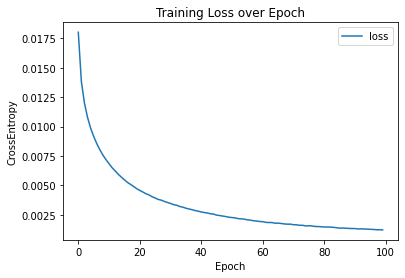

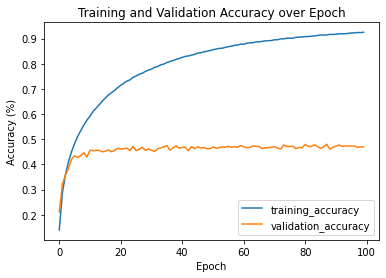

In [49]:
import matplotlib.pyplot as plt

plt.plot(epoch_loss,label = 'loss')
plt.title('Training Loss over Epoch')
plt.xlabel('Epoch')
plt.ylabel('CrossEntropy')
plt.legend()
plt.show()
plt.savefig('loss plot.png')


plt.plot(epoch_acc,label = 'training_accuracy')
plt.plot(epoch_acc_validation, label = 'validation_accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.title('Training and Validation Accuracy over Epoch')
plt.legend()
plt.show()

In [50]:
# validation data

# test = torch.utils.data.TensorDataset(torch.from_numpy(dev_x).to(device=device, dtype=torch.float), torch.from_numpy(dev_y).to(device=device, dtype=torch.long))
# testloader = torch.utils.data.DataLoader(test, batch_size=100, shuffle=False)

model.eval()

pred_res = []

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        # predicted to cpu
        pred_res.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # print('Accuracy of the network on the test data: {} %'.format(100 * correct / total))
    print('Accuracy of the network on the validation data: {} %'.format(100 * correct / total))


Accuracy of the network on the validation data: 46.96 %


In [0]:
pred_res = np.asarray(pred_res)
print(dev_y)
print(pred_res[:5])
print((pred_res == dev_y).sum()/len(pred_res))

In [0]:
# test data
model.eval()
pred_res = []

# torch.FloatTensor(test_x)
with torch.no_grad():
  testdata = torch.FloatTensor(test_x).to(device=device)
  outputs = model(testdata)
  _, predicted = torch.max(outputs.data, 1)
  pred_res.extend(predicted.cpu().numpy())

In [54]:
from typing import List
def write_prediction(prediction: List[int], filename: str):
    with open(filename, 'w') as fp:
        print('Id,Category', file=fp)
        for i, pred in enumerate(prediction):
            print(f'{i},{pred}', file=fp)


write_prediction(pred_res, 'DL_hw_CNN.csv')
!head 'DL_hw_CNN.csv'
!wc -l 'DL_hw_CNN.csv'

Id,Category
0,35
1,24
2,66
3,70
4,39
5,22
6,70
7,14
8,87
10001 DL_hw_CNN.csv


In [55]:
!pip freeze > requirements.txt
!ls

 CNN_model   DL_hw_CNN.csv   epoch_acc_validation  'loss plot.png'
 data.pth    epoch_acc	     epoch_loss		    requirements.txt


# Ref
https://github.com/Armour/pytorch-nn-practice/blob/master/utils/meanstd.py


https://nbviewer.jupyter.org/github/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-lenet5-cifar10.ipynb

https://github.com/pytorch/examples/blob/master/mnist/main.py


# Further Strategy

ResNet

ref: https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/deep_residual_network/main.py
